In [134]:
# import your packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import seaborn as sns
import pymc as pm
import pytensor.tensor as pt  # 这个包主要是用来进行一些张量计算
import arviz as az  

import time
from scipy.stats import beta, binom, norm, gaussian_kde
from scipy.integrate import quad, nquad


## 1 Population Coding

上次作业中我们探究了调谐曲线（tuning curve），即神经元对不同刺激的反应模式（称为encoding过程），本题中我们关心已知调谐曲线和神经元的反应后，解码真实刺激的内容（称为decoding内容），接下来我们假设神经元真实反应模式可用冯·米塞斯（von Mises）曲线进行表示：$$\lambda(\theta) = 100*\exp(\cos(\theta - \theta_0)-1)$$其中 $\theta$ 是真实刺激朝向，$\theta_0$ 是该神经元偏好朝向，而实际观测到的放电次数 $n$ 服从泊松分布：$$
p(n = k; \lambda) = \frac{\lambda^k}{k!}e^{-\lambda}$$其中n是放电次数，而 $\lambda$ 是神经元真实的反应强度。（在这里我们通过-1修正了上次作业中系数A不对应最大放电强度的bug）

1) 假设某个神经元真实反应强度为 $\lambda_0 = \frac{100}{\sqrt{e}}$，其最偏好的朝向为 $\theta_0 = \pi$，假设 $\theta$ 的先验分布为 $[0, 2\pi]$之间的均匀分布，请使用贝叶斯公式推导出 $\theta$ 的后验分布 $p(\theta|\lambda)$（5分）；

这是一道完全通过推导解决的问题，从 $\lambda$ 到 $\theta$ 的关系是确定性（deterministic）的，所以**似然函数**是指示函数 $$\mathcal{L}(\theta; \lambda_0) = p(\lambda_0; \theta) = I(\lambda = 100 * \exp(\cos(\theta - \pi) -1))$$带入已知条件 $\lambda_0 = \frac{100}{\sqrt{e}}$ 求解方程得出$\theta = 2\pi/3$ 或者 $\theta = 4\pi/3$处的似然为 $1$，其他位置 $\theta$ 的似然均为 $0$（显然似然函数是不满足归一化条件的）。**先验分布**为均匀分布 $$p(\theta) = \frac{1}{2\pi}I(0\leq\theta\leq2\pi)$$根据**贝叶斯公式**可以得出未归一化的后验分布$$p(\theta|\lambda) \propto p(\theta)\mathcal{L}(\theta; \lambda)$$也只在$\theta = 2\pi/3$ 或者 $\theta = 4\pi/3$ 处非0，归一化后得到后验分布 $p(2\pi/3 |\lambda_0) = p(4\pi/3\lambda_0) = 0.5$，其他位置的 $p(\theta|\lambda_0)$ = 0。

note: 其实这里似然函数更严格的写法应该是dirac delta函数（因为lambda的取值是连续的） $\delta(\lambda = 100 * \exp(\cos(\theta - \pi) -1))$, 相应的（归一化后的）后验分布为$$\frac12(\delta(\theta - 2\pi/3) + \delta(\theta - 4\pi/3))$$但是请注意，如果你将delta视作连续变量，这是没有办法归一化得到样本概率密度为1/2的结论的



2) 真实反应强度无法直接观测得到，假设对（1）相同的神经元，我们观测到的放电次数为 $n = 70$。请在 $\theta$ 的先验分布不变的前提下，请画出概率图模型，使用MCMC采样的方法，画出 $\theta$ 的后验分布 $p(\theta|n)$，并说明本例能否使用后验均值作为 $\theta$ 的估计值（10分）；

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


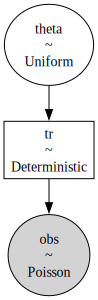

In [198]:
# 概率图模型，采样
with pm.Model() as model1:
    best_ori, response1 = np.pi, 70
    theta = pm.Uniform("theta", lower = 0, upper = 2 * np.pi)
    tune_rate = pm.Deterministic('tr', 100 * np.exp(np.cos(best_ori - theta) - 1))
    obs = pm.Poisson("obs", mu = tune_rate, observed = response1)
    trace = pm.sample(2000, progressbar=False)  # progressbar=False只是为了不显示采样进度条结果更紧凑
pm.model_to_graphviz(model1)

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

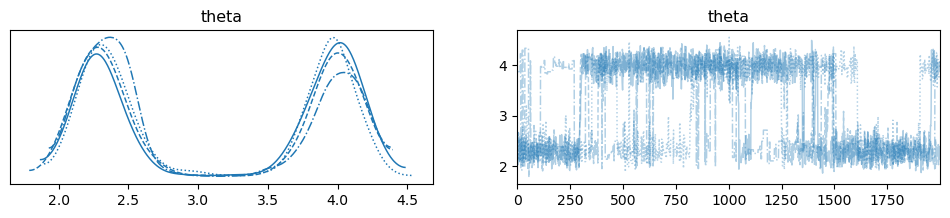

In [ ]:
az.plot_trace(trace, var_names=["theta"])  # trace的结果可以很好可视化不收敛的情况

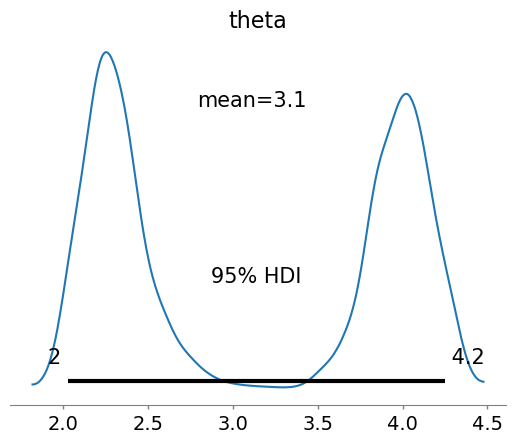

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,3.114,0.862,2.028,4.223,0.120,0.085,86.0,259.0,1.03
tr,71.308,9.134,54.601,87.425,0.412,0.292,474.0,275.0,1.02


In [8]:
az.plot_posterior(trace, var_names='theta', hdi_prob=0.95)
plt.show()
az.summary(trace)

结果：后验分布 $p(\theta|n)$ 为双峰分布，95% HDI非常宽 [2, 4.2]，$\hat r >0.01$ 说明不同链的结果不收敛，后验均值不具有代表性

3) 概率群体编码理论认为，真实刺激的朝向是多个神经元共同编码的，`pc.csv`记录了中颞区皮层（MT）中100个神经元对**同一刺激**的反应，`ori`表示该神经元最偏好的朝向（用弧度制表示），`spike`列记录的观测到的放电次数，根据 100 个神经元的放电情况，画出 $\theta$ 的后验分布 $p(\theta|n)$，并报告后验均值和95%HDI（10分）；

In [202]:
pc_data = pd.read_csv('pc.csv', index_col=0)  # index_col=0表示将第一列作为索引列，可以避免很丑陋的行号
best_ori, response100 = pc_data.best_ori.values, pc_data.response.values
# pc_data.head()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [pred_spike]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


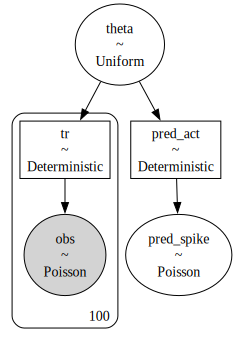

In [ ]:
with pm.Model() as model100:
    theta = pm.Uniform("theta", lower = 0, upper = 2 * np.pi)
    tune_rate = pm.Deterministic('tr', 100 * np.exp(np.cos(best_ori - theta) - 1))
    obs = pm.Poisson("obs", mu = tune_rate, observed = response100)
    pred_act = pm.Deterministic('pred_act', 100 * np.exp(np.cos(np.pi - theta) - 1))
    pred_spike = pm.Poisson("pred_spike", pred_act)  # 这两行是为第四问服务的
    trace = pm.sample(2000, progressbar=False)
pm.model_to_graphviz(model100)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.062,0.024,2.018,2.11,0.0,0.0,3143.312,5319.571,1.003


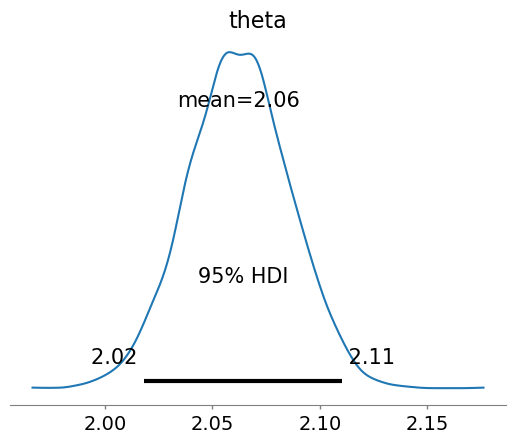

In [24]:
az.plot_posterior(trace, var_names=['theta'], hdi_prob=0.95, round_to=3)
az.summary(trace, var_names=['theta'], hdi_prob=0.95, round_to=3)

结果：后验分布 $p(\theta|n)$ 的期望为 $2.06$, 95% HDI 为 $[2.02, 2.11]$

4) 请你根据上一问中 $\theta$ 的后验分布进行预测，对于（1）中最偏好朝向为 $\theta_0 = \pi$ 度的神经元，绘制其真实反应强度和记录到放电次数的后验预测分布，并比较他们的均值。（10分，提示，你可以手动将这个神经元添加到上一问的图模型中获得他们的后验分布），（非常抱歉这道题写错了，（1）中偏好的朝向是 $\theta_0 = \pi$ 而不是 $\theta_0 = 0$，这里已经修改，批改时写那个都可以）

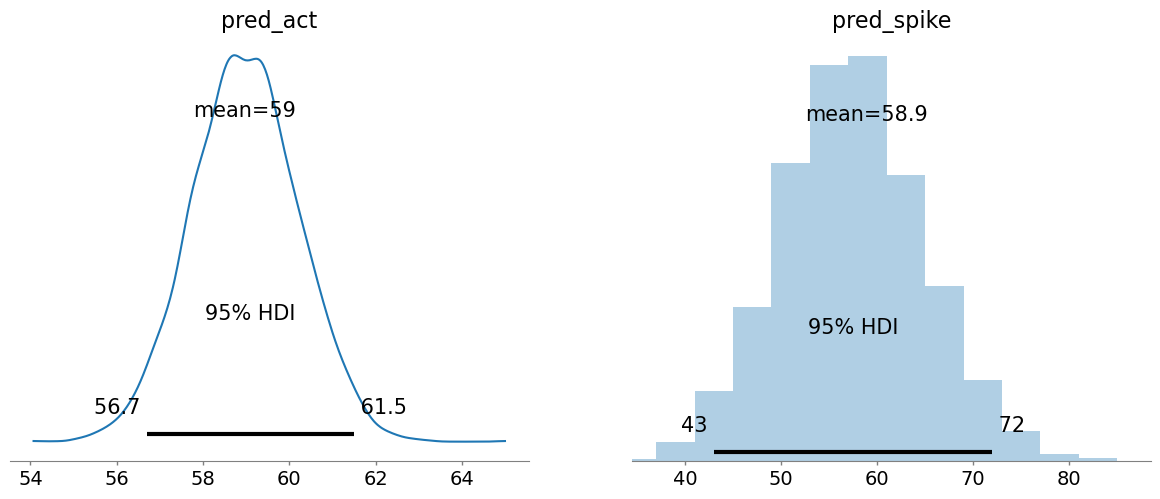

In [41]:
# 简单粗暴的做法是在图模型中添加两个节点同时进行采样
az.plot_posterior(trace, var_names=['pred_act', 'pred_spike'], hdi_prob = 0.95, round_to=3)
plt.show()

Sampling: [pred_spike]


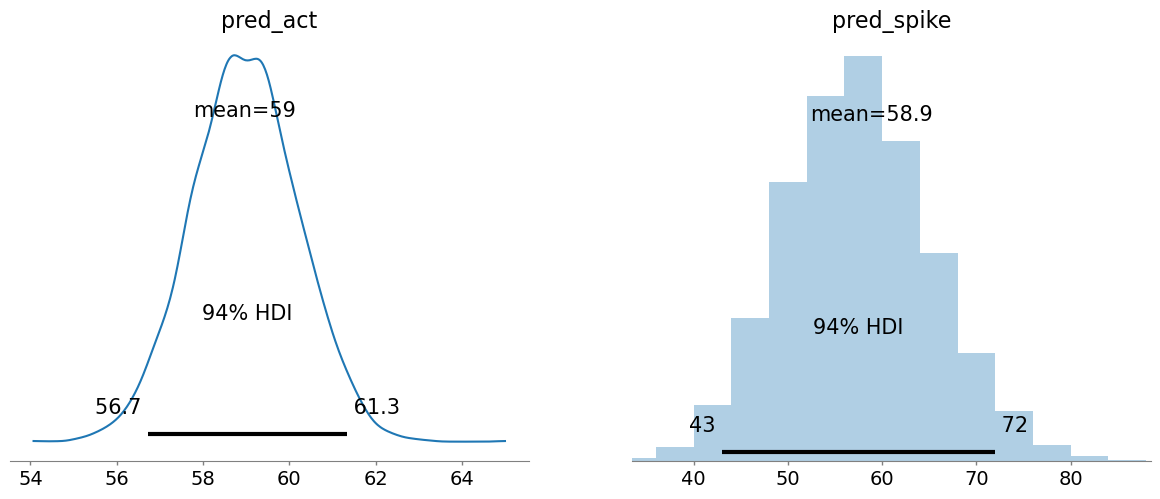

In [53]:
# 另一种做法是使用arviz的plot_posterior_predictive函数来进行后验预测
with model100:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['pred_act', 'pred_spike'], progressbar=False, random_seed=42)
# az.plot_posterior_predictive(post_pred, var_names=['pred_act', 'pred_spike'], hdi_prob=0.95, round_to=3)
az.plot_posterior(post_pred.posterior_predictive, round_to=3)
plt.show()

5) 你认为参与编码的神经元数量对刺激编码的效果有怎样的影响，尝试用现有数据证明你的猜想（5分）。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.035,0.075,1.886,2.181,0.001,0.001,3120.786,5482.119,1.003


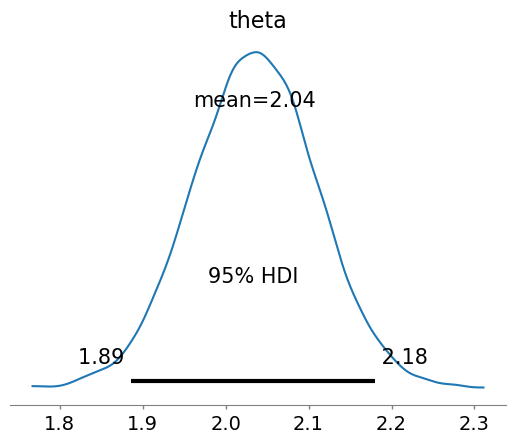

In [ ]:
best_ori10, response10 = best_ori[:10], response100[:10]
with pm.Model() as model10:
    theta = pm.Uniform("theta", lower = 0, upper = 2 * np.pi)
    tune_rate = pm.Deterministic('tr', 100 * np.exp(np.cos(best_ori10 - theta) - 1))
    obs = pm.Poisson("obs", mu = tune_rate, observed = response10)
    trace = pm.sample(2000, progressbar=False)
az.plot_posterior(trace, var_names='theta', hdi_prob = 0.95, round_to=3)
az.summary(trace, var_names='theta', hdi_prob=0.95, round_to=3)

当使用全部100个神经元进行编码时，后验分布的均值为2.062，标准差0.024，95%HDI为[2.018, 2.11], $\hat r$ = 1.003 \
而只使用10个神经元进行编码，后验分布的均值为2.035，标准差0.075，95%HDI为[1.886, 2.181], $\hat r$ = 1.003 \
使用更少的神经元（但不能只有1个）表征，均值是相对准确的，但是后验分布的标准差明显大了很多，参与编码的神经元越多编码越精确。


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.


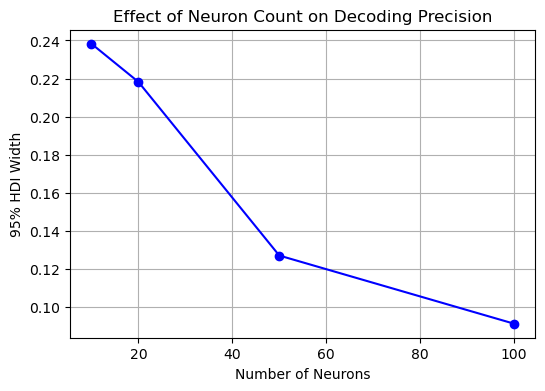

In [ ]:
# 这里摘录了同学作业中更系统地比较结果，有删改
# Function to run the model with a subset of neurons
def run_model_with_neurons(best_ori_subset, responses_subset):
    with pm.Model() as model:
        # Prior for theta (uniform over [0, 2π])
        theta = pm.Uniform("theta", lower=0, upper=2 * np.pi)
        
        # Compute lambda for each neuron based on the von Mises tuning curve
        lambdas = pm.Deterministic("lambda", 100 * pt.exp(pt.cos(theta - best_ori_subset) - 1))
        
        # Likelihood: Poisson distribution for observed responses
        n = pm.Poisson("n", mu=lambdas, observed=responses_subset)
        
        # MCMC sampling
        trace = pm.sample(1000, tune=500, random_seed=42, progressbar=False)
    return trace

# Test with different numbers of neurons
neuron_counts = [10, 20, 50, 100]
hdi_widths = []

for count in neuron_counts:
    # Randomly sample neurons
    indices = np.random.choice(len(best_ori), count, replace=False)  # 额外引入了随机性
    best_ori_subset = best_ori[indices]
    responses_subset = response100[indices]
    
    # Run the model
    trace = run_model_with_neurons(best_ori_subset, responses_subset)
    
    # Compute 95% HDI for theta
    hdi = az.hdi(trace, var_names=["theta"], hdi_prob=0.95)["theta"]
    hdi_width = hdi.sel(hdi="higher") - hdi.sel(hdi="lower")
    hdi_widths.append(hdi_width.values)

    # Plot posterior distribution for this subset
    # az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95)
    # plt.title(f"Posterior Distribution of θ (Neurons: {count})")
    # plt.xlabel("θ (radians)")
    # plt.show()

# Plot HDI widths vs. neuron counts
plt.figure(figsize=(6, 4))
plt.plot(neuron_counts, hdi_widths, "-o", color="blue")
plt.title("Effect of Neuron Count on Decoding Precision")
plt.xlabel("Number of Neurons")
plt.ylabel("95% HDI Width")
plt.grid()
plt.show()

## 2 Why We Use MCMC

**完整贝叶斯公式**如下所示：
$$ p(\theta | x) = \frac{p(x|\theta)p(\theta)}{\int p(x|\theta')p(\theta')d\theta'}\tag{1}$$ 
分母项是一个与 $\theta$ 无关的常数，需要进行积分计算，由于我们并不一定知道其值，上式也常常写成

$$ p(\theta|x) \propto p(x|\theta)p(\theta)\tag{2}$$
这样做的一个好处在于，如果likelihood ($p(x|\theta)$)和先验的形式我们都知道，那么一定情况下后验分布仍然满足某一分布。在张老师给大家的课件`BayesUpdateCoin.ipynb`中就利用了这种特性。在对应代码中，似然函数是`二项分布`, 先验分布是`beta分布`，而`beta分布`恰好是`二项分布`的共轭分布(which means 后验分布也是`beta分布`的形式，证明可参考`lecture4 slides中27页`)。尽管共轭分布为计算后验提供了一种方式，对于一些概率分布我们较难找到其共轭分布，而直接计算分母项在低维空间中则是容易的。,

1) (低维贝叶斯计算)请你用**完整贝叶斯公式**来计算下面的例子：假设扔一枚硬币，其正面朝上概率为p，不同投掷彼此之间独立。$p$ 的先验概率分布为 $\text{Beta}(2,3)$, 现在投了 $10$ 次，有 $7$ 次正面朝上，请你按照如下步骤，利用贝叶斯公式(2)计算 $p$ 的后验概率并进行可视化（10分）。
- 定义先验分布 $p(\theta)$ 和似然函数 $p(x|\theta)$，可能会用到scipy.stats（for Python）或dxxxx（for R）；
- 计算积分 $\int p(x|\theta)p(\theta)d\theta$，可能会用到scipy.integrate（for Python）或integrate（for R）；
- 可视化先验分布 $p(\theta)$、似然函数 $p(x|\theta)$ 和（归一化后的）后验分布 $p(\theta | x)$。

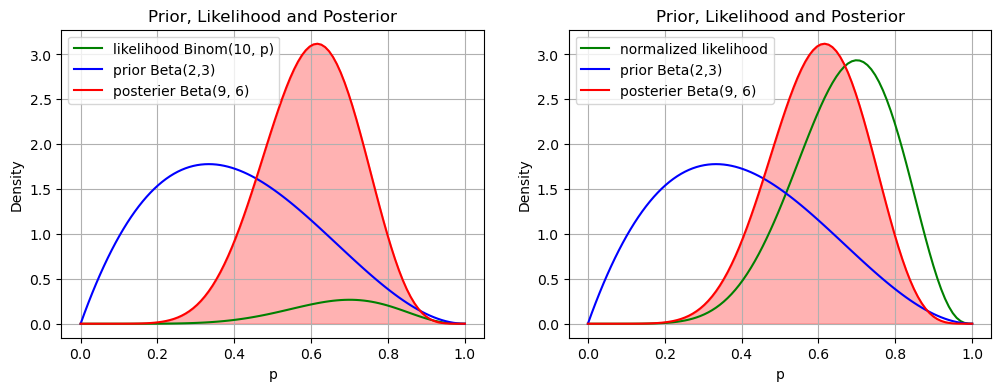

In [79]:
n = 10  # 投掷次数
k = 7   # 正面朝上次数

# 定义先验分布
def prior(p):
    return beta.pdf(p, 2, 3)

# 定义似然函数
def likelihood(p):
    return binom.pmf(k, n, p)

# 定义后验分布
def unnormalized_posterior(p):
    return likelihood(p) * prior(p)

# 计算分母积分值
normalization_constant, _ = quad(unnormalized_posterior, 0, 1)
normalization_constant_lik, _ = quad(likelihood, 0, 1)

# 计算后验分布
def posterior_normalized(p):
    return unnormalized_posterior(p) / normalization_constant

# 可视化
p = np.linspace(0, 1, 100)
prior_values = prior(p)
likelihood_values = likelihood(p)
posterior_values = posterior_normalized(p)

# 在右图中我们将likelihood手动进行了normalization（出于可视化效果的考量），一般情况下积分是不为1的
# 事实上只相差一个乘积因子的likelihood对posterior的贡献是没有区别的
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(p, likelihood_values, label='likelihood Binom(10, p)', color='green')
ax[1].plot(p, likelihood_values/normalization_constant_lik, label='normalized likelihood', color='green')
for i in range(2):
    ax[i].plot(p, prior_values, label='prior Beta(2,3)', color='blue')
    ax[i].plot(p, posterior_values, label='posterier Beta(9, 6)', color='red')
    ax[i].fill_between(p, posterior_values, alpha=0.3, color='red')
    ax[i].set(xlabel = 'p', ylabel = 'Density', title = 'Prior, Likelihood and Posterior')
    ax[i].legend()
    ax[i].grid(True)

plt.show()

2) (高维状态下的贝叶斯-MCMC)
在（1）中你会发现你很快就计算成功了数值，其实对于低维数据，低维积分是很快的，但是如果参数维度相对较高，计算机计算误差较大同时计算用时较久。下面我们来看一个包含多个参数的例子：`lr.csv`中有三列，`y`,`x1`,`x2`，我们希望建模如下的方程：$$ y = k_0 + k_1 x_1 + k_2 x_2 + \epsilon $$其中先验分布满足：$\epsilon \sim N(0, \sigma^2), \sigma \sim U(0, 1)$，$k_i \sim N(0, 1), i = 0, 1, 2$。请你利用MCMC采样估计上述参数、可视化这四个参数的后验均值，同时报告采样所花的时间(请使用print报告），（10分）。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


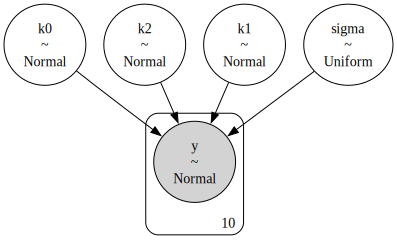

In [215]:
# load data
data = pd.read_csv('lr.csv')
x1, x2, y = data['x1'], data['x2'], data['y']

with pm.Model() as lrmodel:
    # 先验分布
    k1 = pm.Normal('k1', mu=0, sigma=1)
    k2 = pm.Normal('k2', mu=0, sigma=1)
    k0 = pm.Normal('k0', mu=0, sigma=1)
        
    # 线性模型
    mu = k1 * x1 + k2 * x2  + k0
        
    # 似然函数
    sigma = pm.Uniform('sigma', lower = 0, upper = 1)
    y_hat = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

    # 采样
    trace = pm.sample(2000)
pm.model_to_graphviz(lrmodel)


PyMC 采样后验均值: [1.133 0.36  1.254 0.415]
ndraws = 2000，总计耗时18s，其中drawing用时3s


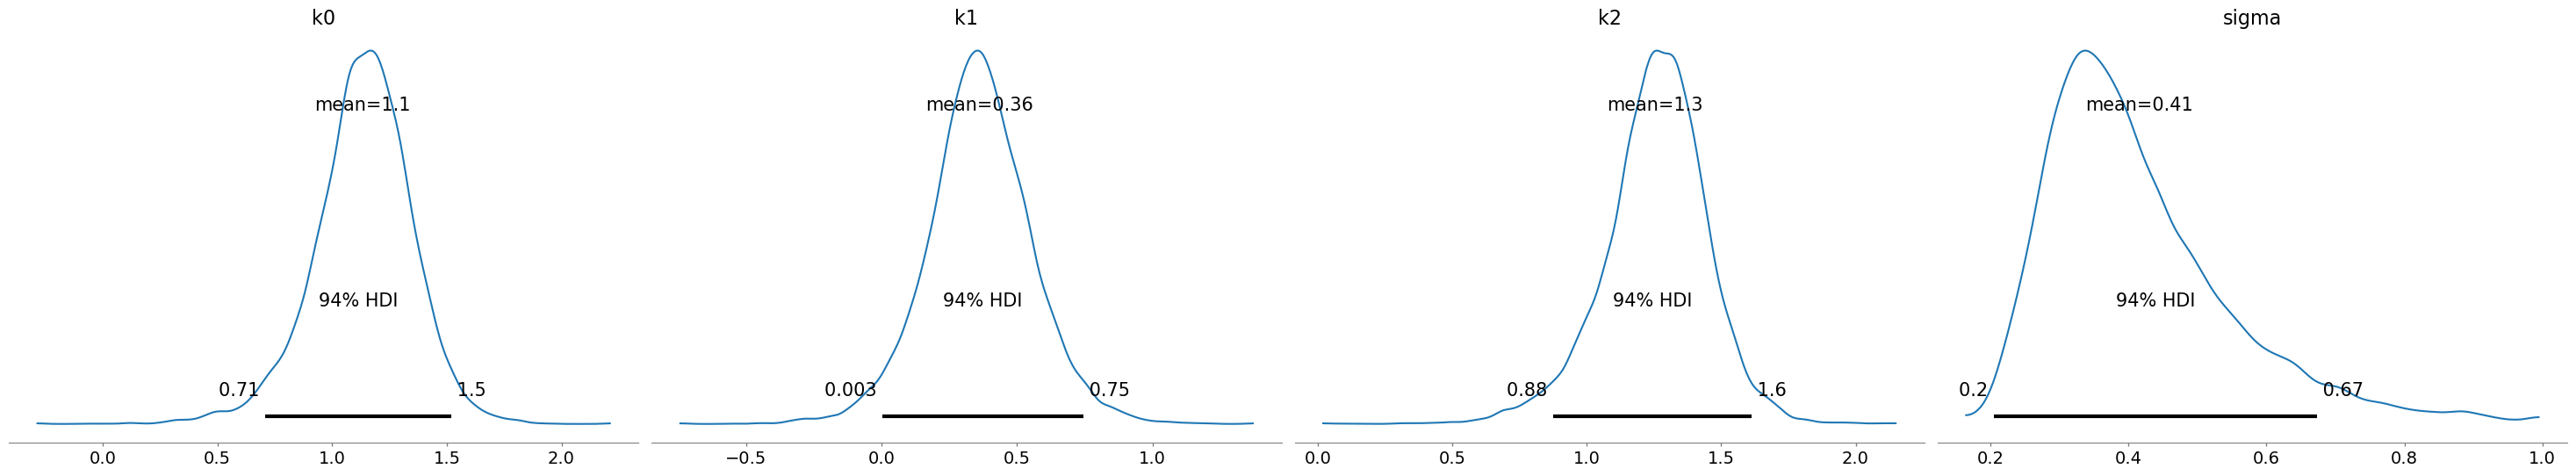

In [216]:
# 提取后验均值
post_mean_pymc = az.summary(trace, hdi_prob=0.95)['mean']
# 绘图
az.plot_posterior(trace)
plt.tight_layout()
print(f'PyMC 采样后验均值: {post_mean_pymc.values}')
print(f'ndraws = 2000，总计耗时18s，其中drawing用时3s')

In [100]:
time_record, trace_record = [], []
for n_draws in [10000, 20000, 30000, 40000]:
    start = time.time()
    with pm.Model() as lrmodel:
        # 先验分布
        k1 = pm.Normal('k1', mu=0, sigma=1)
        k2 = pm.Normal('k2', mu=0, sigma=1)
        k0 = pm.Normal('k0', mu=0, sigma=1)
        
        # 线性模型
        mu = k1 * x1 + k2 * x2  + k0
        
        # 似然函数
        sigma = pm.Uniform('sigma', lower = 0, upper = 1)
        y_hat = pm.Normal('y', mu=mu, tau=sigma, observed=y)
        
        # 采样
        trace_record.append(pm.sample(n_draws, progressbar=True))
    time_record.append((time.time() - start))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 42 seconds.


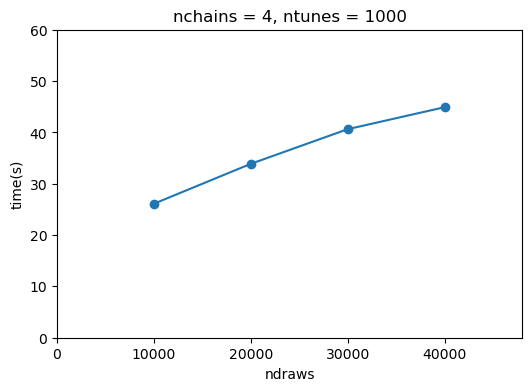

In [ ]:
# PYMC采样用的时间包括：编译时间（就是采样前的准备）+ tuning时间（收敛前调节采样参数）+ draws（收集trace数据）
# draws的速度大概是O(ndraws)的，同时前两步用时可以看作固定时间的，所以回归直线是不过原点的直线，每10000此采样用时大约7s
# 但是对于本题目中的（过于简单的）模型，采样10000次和40000次后验分布的方差是没有区别的
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot([10000, 20000, 30000, 40000], time_record, '-o')
ax.set(xlabel = 'ndraws', ylabel = 'time(s)', title='nchains = 4, ntunes = 1000', ylim = (0, 60), xlim = (0, 48000))
plt.show()

3) （高维状态下的贝叶斯-数值积分）请你使用**完整贝叶斯公式**完成以下计算进行计算（5分）：
- 首先定义先验分布 $p(\theta)$ 和似然函数 $p(x|\theta)$；
- 由于计算复杂性，你可以选择固定 $\sigma=1$，只对三个k参数进行积分
- 计算积分 $\int p(x|\theta)p(\theta)d\theta$ 并报告积分用时，需要用到多重积分的函数，积分上下界建议选择 $[-2, 2]$ ；
- 注意：不需要完成进一步后验分布的计算和报告

In [206]:
# 直接计算
# 积分用时受到积分区间宽度，误差容许度（子区间拆分数量）的影响，这里我们就用了默认参数

def prior_sigma(sigma):
    return 1 if sigma >= 0 and sigma <= 1 else 0

def prior_k(k):
    """先验分布: 正态分布"""
    return norm.pdf(k, loc=0, scale=1)

def prior(k0, k1, k2, sigma):
    return prior_sigma(sigma) * prior_k(k0) * prior_k(k1) * prior_k(k2)

def likelihood(k0, k1, k2, sigma):
    """似然函数: 正态分布"""
    mu = k0 + k1 * x1 + k2 * x2
    return np.prod(norm.pdf(y, loc=mu, scale=sigma))

def integrand(k0, k1, k2):
    """被积函数: likelihood * prior"""
    return likelihood(k0, k1, k2, 1) * prior(k0, k1, k2, 1)
# 计时开始
start_time = time.time()

# 计算归一化常数(分母积分)
bounds = [(-2, 2), (-2, 2), (-2, 2)]

# 计算归一化常数
print('正在计算归一化常数...')
normalization_constant, error = nquad(integrand, bounds)

# 计时结束
end_time = time.time()
computation_time_direct = end_time - start_time

print(f'归一化常数: {normalization_constant}')
print(f'最大误差: {error}')
print(f'计算时间: {computation_time_direct:.4f} 秒')


正在计算归一化常数...
归一化常数: 9.43337377970354e-07
最大误差: 1.4522308398928619e-08
计算时间: 20.5592 秒


In [ ]:
# 出于比较的目的，我们也在固定sigma=1处采样了一下
# 对于MCMC采样3个或者4个变量对时间的影响不大
# 但是如果尝试过对四个变量均进行数值积分，等待时间是相当夸张的
with pm.Model() as lrmodel_sigma1:
    # 先验分布
    k1 = pm.Normal('k1', mu=0, sigma=1)
    k2 = pm.Normal('k2', mu=0, sigma=1)
    k0 = pm.Normal('k0', mu=0, sigma=1)
    mu, sigma = k1 * x1 + k2 * x2  + k0, 1
    y_hat = pm.Normal('y', mu=mu, tau=sigma, observed=y)
    trace = pm.sample(2000, progressbar=False)
k0_MCMC_trace = trace.posterior.k0.values.flatten()
k0_MCMC_density = gaussian_kde(k0_MCMC_trace)  # 手动拟合density，和az.plot_posterior结果是一样的


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k0]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


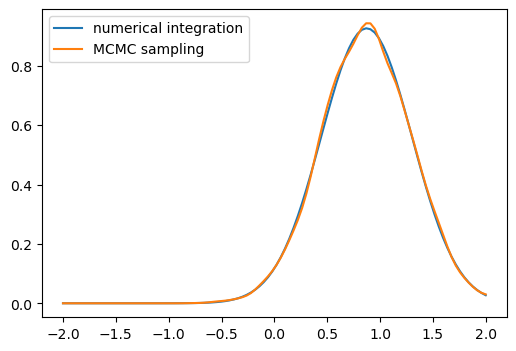

In [ ]:
# 现在对于任意参数 (k0, k1, k2)，我们都可以准确计算出他的后验分布 p(k0, k1, k2|x, y, sigma)，但是我们要怎么画出单个的先验分布 p(k_0|x, y, sigma) 呢，答案是对联合分布进行积分得到边缘分布
# MCMC和数值积分的精确度相近，虽然数值积分结果更稳定，但是计算边缘分布是额外的计算，MCMC则可以直接得到结果
def k0mariginal(k0):
    def integrand0(k1, k2):
        return likelihood(k0, k1, k2, 1) * prior(k0, k1, k2, 1)
    bounds = [(-2, 2), (-2, 2)]
    prob, _ = nquad(integrand0, bounds)
    return prob / normalization_constant


k0s = np.linspace(-2, 2, 100)
pk0 = np.array([k0mariginal(k0) for k0 in k0s])
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.plot(k0s, pk0, label = 'numerical integration')
ax.plot(k0s, k0_MCMC_density(k0s), label = 'MCMC sampling')
plt.legend()

4) （为什么MCMC更快）对比多元回归中的两个问题，你会发现好像MCMC的方法的确要比计算积分式求解更快（如果你考虑 $\sigma$ 的分布，并进行四重积分，运算时间将会远超过30min），请结合下面关于算法和复杂度的介绍，说说为什么MCMC相比使用贝叶斯公式进行积分在计算速度上具有优势（5分）


（1）计算复杂度：这里我们只关注大O表示法下的时间复杂度，大概就是表示执行算法所需要的操作次数，可以认为，执行一次操作的复杂度是 $O(1)$ ，如果用for循环重复 $n$ 次计算复杂度为 $O(n)$，$d$ 个for循环的复杂度是 $O(n^d)$，以此类推。

（2）对于数值积分，如果是一维积分，常常把积分区间划分成很 $N$ 个小份(如下图)，然后用矩形面积（对应位置的函数值乘bins的宽度，可以看作1次O(1)操作），求和后近似积分结果，即$S = \sum_{i=1}^n f(x_i) \Delta_x$, 如果是二维则需要划分成 $N\times N$的小份，以此类推d维则需要对d个维都进行划分。

（3）对于mcmc，以ppt上的Metropolis 算法为例，大概的算法如下（详情可以参考ppt）：
- 首先定义参数的初始值 $\theta_{current}$，以及采样次数 $M$; 
- 其次根据提倡分布（比如$q(\theta_{proposed}|\theta_{current}) = N(\theta_{current}, \sigma^2)$）采样的到 $\theta_{proposed}$，这一步用时可以忽略；
- 根据公式 $p_{move} = \min(\frac{p(\theta_{proposed})p(x|\theta_{proposed})}{p(\theta_{current}p(x|\theta_{current})}, 1)$，可以看作一次O(1)操作；
- 以概率 $p_{move}$ 将参数更新为 $\theta_{proposed}$，以概率 $1-p_{move}$ 参数保留为 $\theta_{current}$，这一步用时可以忽略；
- 重复2-4的操作 $M$ 次。


因为随着维数增加，正常积分复杂度O(N^d)，指数级递增；而MCMC则是O(M)，线性递增。因此MCMC更具优势。一般来说，数值积分仅适用于1-3维的推断问题，更高维度的计算开销是难以接受的。

## 3 Coffee or Beer 
在一项食品研究中，研究人员想要区分两类专业人士的口味偏好：
- **咖啡师**：专长于咖啡的风味、烘焙程度、酸度等；
- **酿酒师**：专长于啤酒的苦度、麦芽风味、酒精发酵工艺等。

研究人员提供了一系列饮品样本，其中包括咖啡变种与啤酒变种，参与者品尝每种饮品并给出评分(评分范围0-5，为连续值)。`cb.csv`中储存了不同`rater`对不同`drink`的打分。现有以下两种假设：
- **H1(职业影响口味偏好)**：咖啡师给咖啡评分($\alpha_0$)比啤酒分数($\beta_0$)更高，而酿酒师给啤酒评分($\alpha_1$)比咖啡分数更高($\beta_1$)。同时咖啡师给分极差更大($\beta_0$ < $\beta_1$ <$\alpha_1$ < $\alpha_0$)。
- **H2(跨界专家的影响)**： 除了H1中给出的咖啡师和酿酒师外，还有一群风味专家混进了评分队伍，他们是研究食品风味的科学家，对不同风味有自己研究，对啤酒和咖啡并无给分高低之分，但由于见多识广,评分($\theta$)不高不低($\beta_0$ < $\beta_1$ < $\theta$ < $\alpha_1$ < $\alpha_0$) 

假设每次给分时，对于每个人每个饮品噪音$\sigma$相同(可参考`two country quiz`的例子进行作答)。**与此同时，研究人员认识0号评分者，知道他是一个酿酒师(hints：想想这个对应着`two country quiz`中pymc模型定义的哪部分, 如果在H2中这个信息如何利用)。**

1) 请为上述参数（包含$\sigma$）设置合理的先验分布，并绘制出H1和H2的graphical model（10分）；

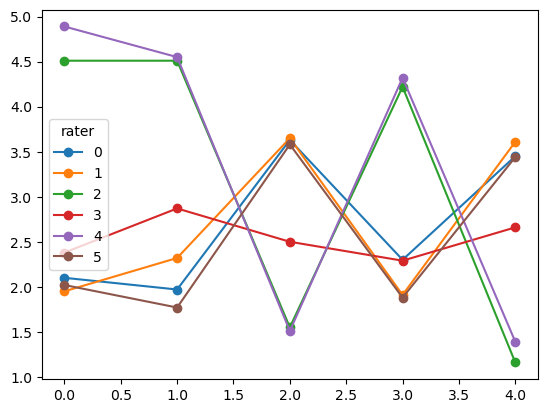

In [172]:
# load data
data = pd.read_csv('cb.csv')
scores = data[['drink1', 'drink2', 'drink3', 'drink4', 'drink5']].values
n, drinks = scores.shape

# 数据可视化是很好的习惯
plt.plot(scores.T, '-o', label = data.rater)
plt.legend(title = 'rater')
# rater 2, 4，rater 0, 1, 5, rater 3似乎有着不同的打分风格

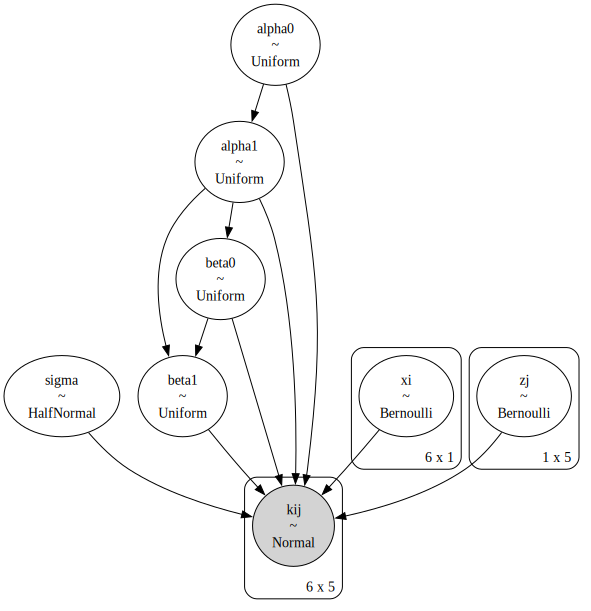

In [174]:
# 设置模型
with pm.Model() as modelH1:
    # 设置超参数
    noise = pm.HalfNormal('sigma', sigma=0.5)
    alpha0 = pm.Uniform('alpha0', lower=0., upper=5.)
    alpha1 = pm.Uniform('alpha1', lower=0., upper=alpha0)
    beta0 = pm.Uniform('beta0', lower=0., upper=alpha1)
    beta1 = pm.Uniform('beta1', lower=beta0, upper=alpha1)
    
    # 设置 xi 和 zj
    xi = pm.Bernoulli('xi', p=np.array([1]+[0.5]*(n-1)).reshape(-1, 1), shape=(n, 1))
    zj = pm.Bernoulli("zj", p=0.5, shape=(1, drinks))
    
    # 设置参数 theta，使用嵌套的 pt.switch 进行二重判定
    mu = pt.switch(
        pt.eq(xi, zj),
        pt.switch(pt.eq(xi, 0), alpha0, alpha1),
        pt.switch(pt.eq(xi, 0), beta0, beta1)
    )
    
    kij = pm.Normal('kij', mu=mu, sigma=noise, observed=scores)

pm.model_to_graphviz(modelH1)

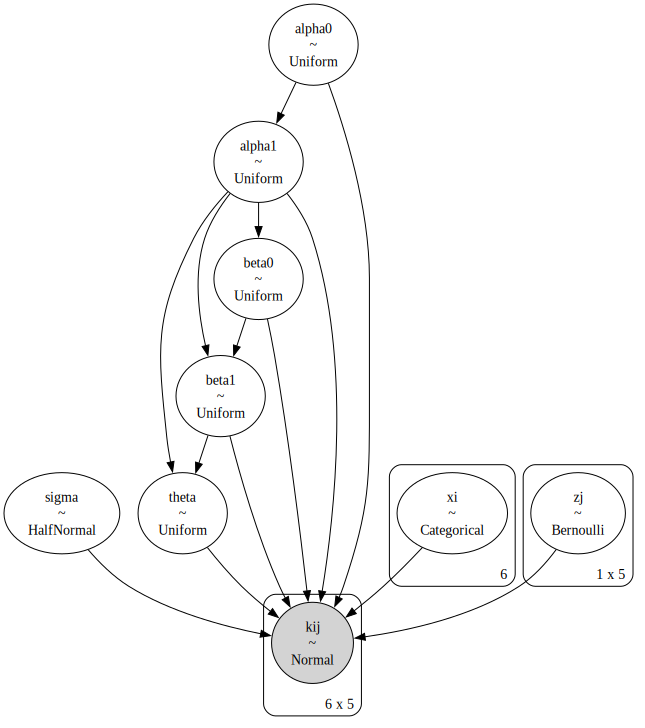

In [182]:
# 设置模型
with pm.Model() as modelH2:
    # 设置超参数
    noise = pm.HalfNormal('sigma', sigma=0.5)
    alpha0 = pm.Uniform('alpha0', lower=0., upper=5.)
    alpha1 = pm.Uniform('alpha1', lower=0., upper=alpha0)
    beta0 = pm.Uniform('beta0', lower=0., upper=alpha1)
    beta1 = pm.Uniform('beta1', lower=beta0, upper=alpha1)
    theta = pm.Uniform('theta', lower=beta1, upper=alpha1)
    
    # 设置 xi 和 zj
    
    xi_probs = np.vstack([[0, 1, 0]] + [[1/3, 1/3, 1/3]] * (n - 1))
    xi_probs = pt.as_tensor_variable(xi_probs)
    xi = pm.Categorical('xi', p=xi_probs, shape=(n, ))
    xi = xi[:, None]
    zj = pm.Bernoulli("zj", p=0.5, shape=(1, drinks))
    
    # 设置参数 theta，使用嵌套的 pt.switch 进行二重判定
    mu = pt.switch(
        pt.eq(xi, 2),
        theta,
        pt.switch(
            pt.eq(xi, zj),
            pt.switch(pt.eq(xi, 0), alpha0, alpha1),
            pt.switch(pt.eq(xi, 0), beta0, beta1)
        )
    )
    
    kij = pm.Normal('kij', mu=mu, sigma=noise, observed=scores)

pm.model_to_graphviz(modelH2)

2) 在此问中分别运行H1和H2中的模型，请在答案中完成如下要求（10分）
- 对于H1：分别绘制$\beta_0$，$\beta_1$，$\alpha_0$ , $\alpha_1$，$\sigma$的后验分布并标注出95% HDI区间
- 对于H2：分别绘制$\beta_0$，$\beta_1$，$\alpha_0$ , $\alpha_1$，$\sigma$，$\theta$的后验分布并标注出95% HDI区间
- 报告两个模型参数相应的收敛性指标，同时回答对于H2，模型认为哪个评分者是风味专家

In [183]:
# model1 sampling
with modelH1:
    trace1 = pm.sample()

with modelH2:
    trace2 = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, alpha0, alpha1, beta0, beta1]
>BinaryGibbsMetropolis: [xi, zj]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
c:\Users\asus\miniconda3\envs\pymc\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, alpha0, alpha1, beta0, beta1, theta]
>CategoricalGibbsMetropolis: [xi]
>BinaryGibbsMetropolis: [zj]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
c:\Users\asus\miniconda3\envs\pymc\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


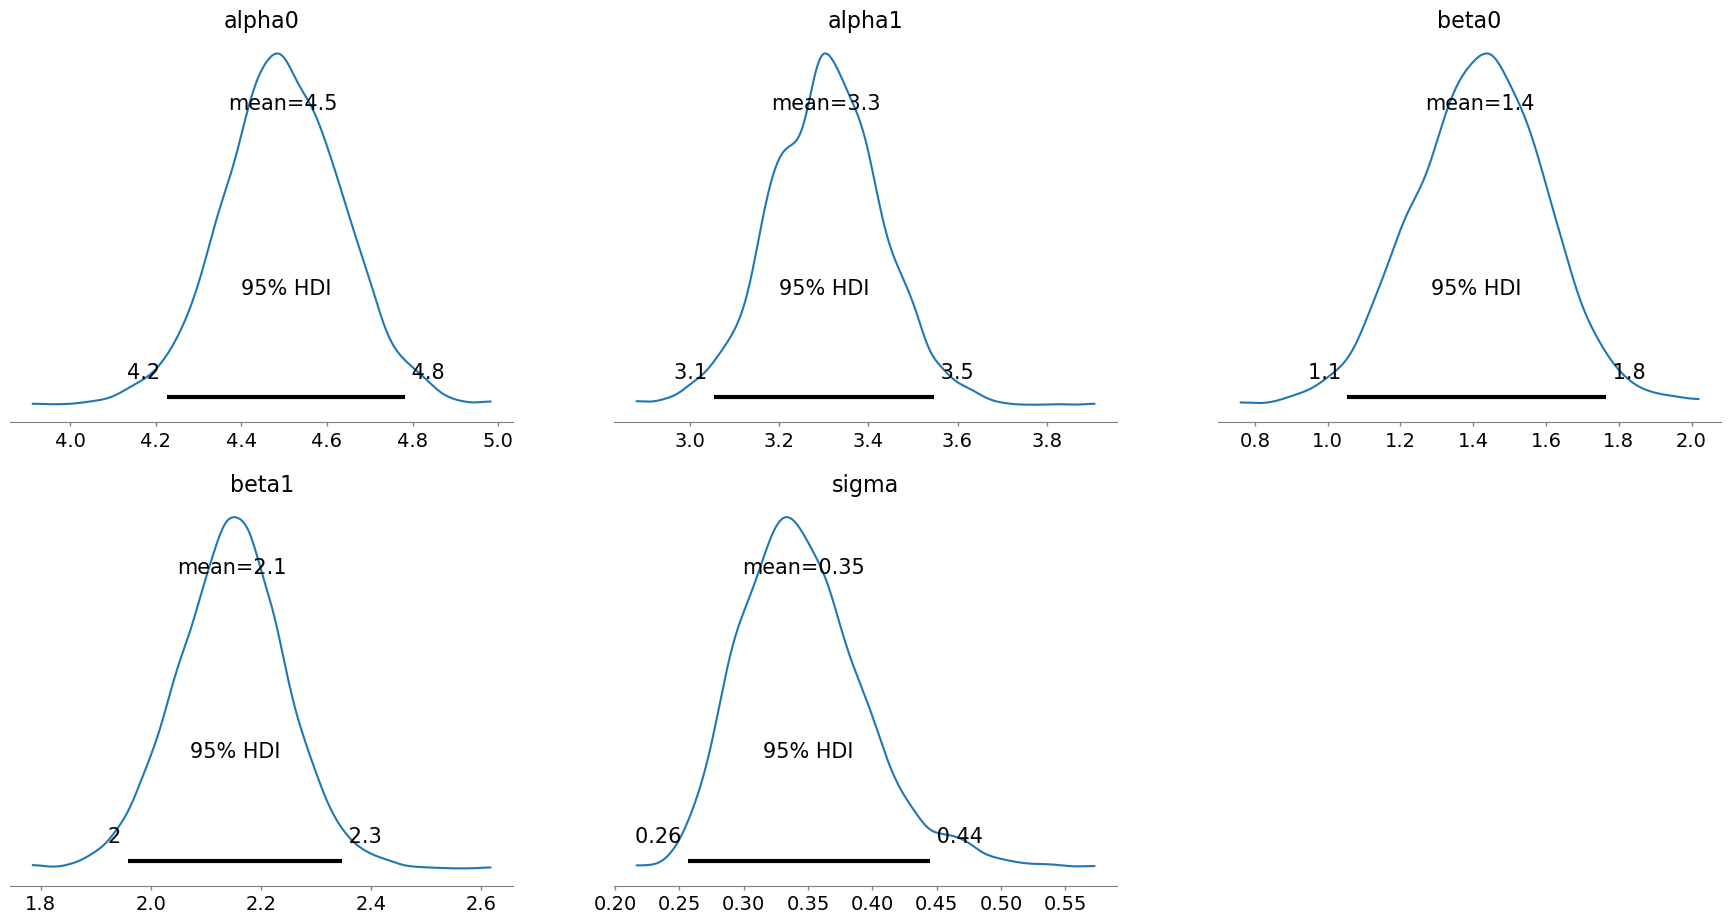

In [184]:
az.plot_posterior(trace1, var_names=['alpha0', 'alpha1', 'beta0', 'beta1', 'sigma'],
                  hdi_prob=0.95, round_to=2)
plt.show()

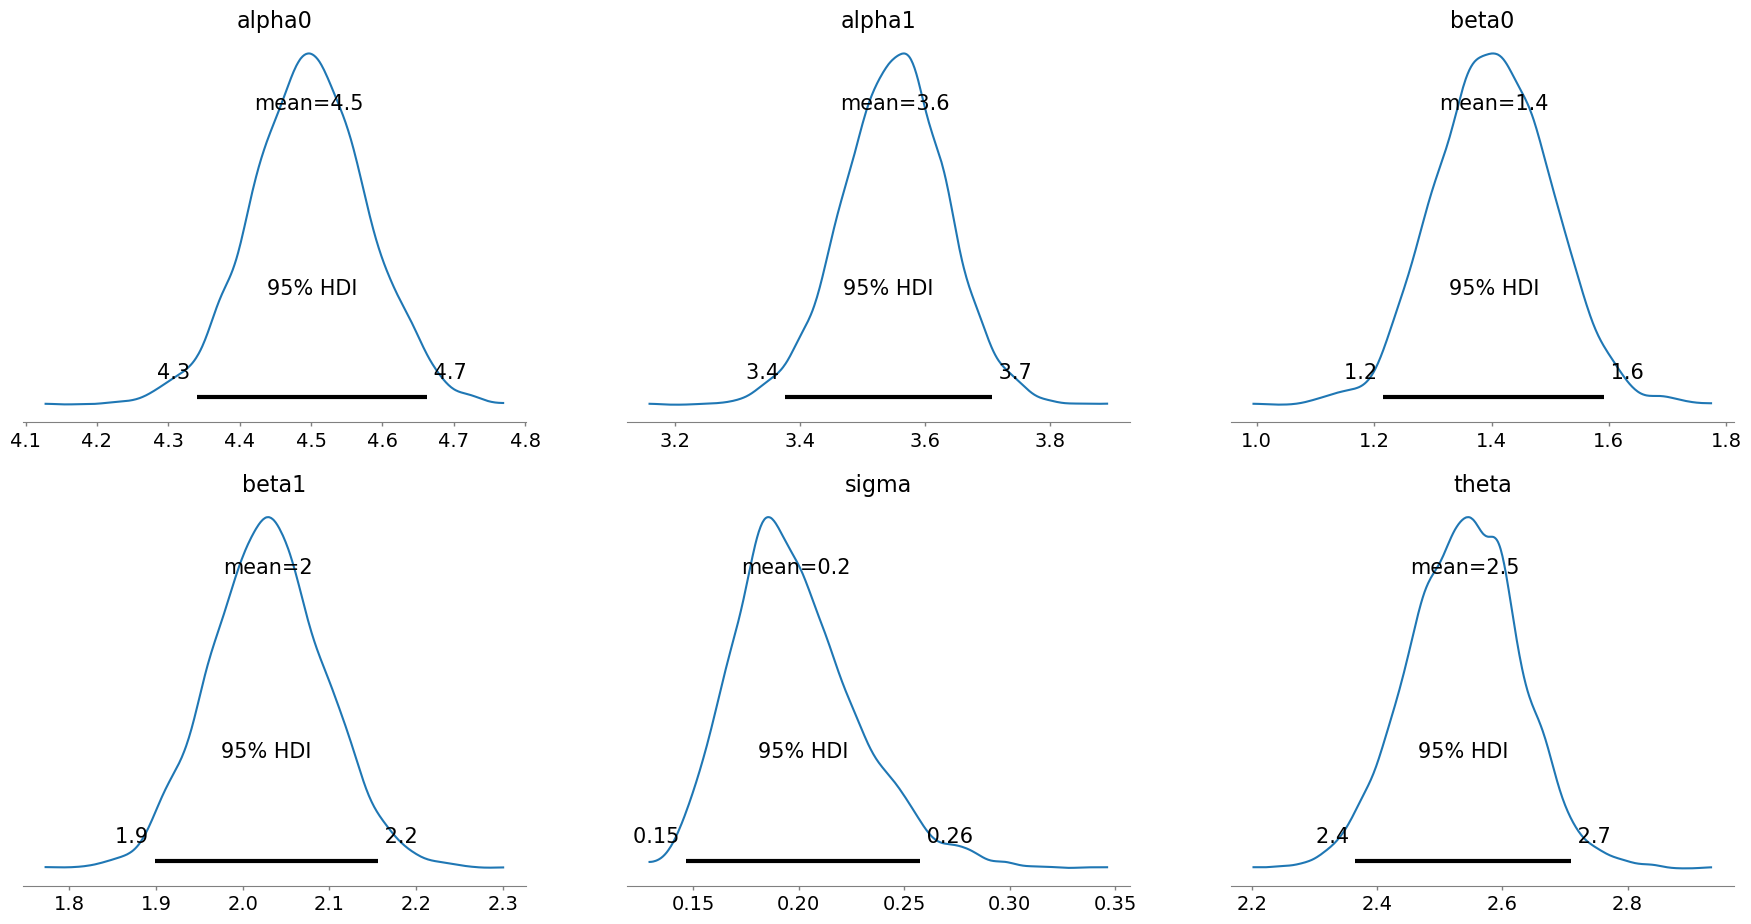

In [185]:
az.plot_posterior(trace2, var_names=['alpha0', 'alpha1', 'beta0', 'beta1', 'sigma', 'theta'],
                  hdi_prob=0.95, round_to=2)
plt.show()

In [186]:
az.summary(trace1, var_names=['alpha0', 'alpha1', 'beta0', 'beta1', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,4.496,0.140,4.232,4.761,0.003,0.002,2509.0,1958.0,1.0
alpha1,3.305,0.124,3.070,3.539,0.002,0.001,3585.0,2622.0,1.0
beta0,1.418,0.182,1.092,1.767,0.004,0.003,2265.0,2241.0,1.0
beta1,2.147,0.099,1.958,2.329,0.002,0.001,4310.0,3165.0,1.0
sigma,0.346,0.049,0.259,0.437,0.001,0.001,3035.0,2363.0,1.0


In [187]:
az.summary(trace2, var_names=['alpha0', 'alpha1', 'beta0', 'beta1', 'sigma', 'theta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,4.498,0.082,4.346,4.653,0.002,0.001,2957.0,2570.0,1.0
alpha1,3.551,0.084,3.388,3.701,0.001,0.001,4023.0,3202.0,1.0
beta0,1.404,0.098,1.216,1.576,0.002,0.001,2768.0,2407.0,1.0
beta1,2.029,0.067,1.905,2.153,0.001,0.001,4055.0,3377.0,1.0
sigma,0.199,0.030,0.147,0.254,0.001,0.000,2758.0,2529.0,1.0
theta,2.539,0.089,2.368,2.699,0.001,0.001,4081.0,2695.0,1.0


In [194]:
az.summary(trace2, var_names=['xi'], kind = 'stats', hdi_prob= 0.95)  # 避免看到r hat = NaN 的恼人结果

,mean,sd,hdi_2.5%,hdi_97.5%
xi[0],1.0,0.0,1.0,1.0
xi[1],1.0,0.0,1.0,1.0
xi[2],0.0,0.0,0.0,0.0
xi[3],2.0,0.0,2.0,2.0
xi[4],0.0,0.0,0.0,0.0
xi[5],1.0,0.0,1.0,1.0


根据rhat（都连续变量）和hdi（对分组变量）的结果，3个模型于在第二个model中可以看到x[3]归类为2，因此3号评分者为风味专家

3) 请分别从waic和loo来比较两个假设，说明哪个模型更合理。(10分)

In [ ]:
with modelH1:
    pm.compute_log_likelihood(trace1)
    waic_h1 = pm.waic(trace1)
    loo_h1 = pm.loo(trace1)
with modelH2:
    pm.compute_log_likelihood(trace2)
    waic_h2 = pm.waic(trace2)
    loo_h2 = pm.loo(trace2)

c:\Users\asus\miniconda3\envs\pymc\Lib\site-packages\arviz\stats\stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\asus\miniconda3\envs\pymc\Lib\site-packages\arviz\stats\stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [212]:
waic_comparison

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
H2,0,3.811502,5.076108,0.000000,1.000000e+00,3.442718,0.000000,True,log
H1,1,-12.632641,4.402004,16.444143,1.222134e-12,4.459088,5.017069,True,log


WAIC Comparison:
    rank  elpd_waic    p_waic  elpd_diff        weight        se       dse  \
H2     0   3.811502  5.076108   0.000000  1.000000e+00  3.442718  0.000000   
H1     1 -12.632641  4.402004  16.444143  1.222134e-12  4.459088  5.017069   

    warning scale  
H2     True   log  
H1     True   log  

LOO Comparison:
    rank   elpd_loo     p_loo  elpd_diff  weight        se       dse  warning  \
H2     0   3.601078  5.286532   0.000000     1.0  3.509206  0.000000    False   
H1     1 -12.811917  4.581280  16.412996     0.0  4.541274  5.110615    False   

   scale  
H2   log  
H1   log  


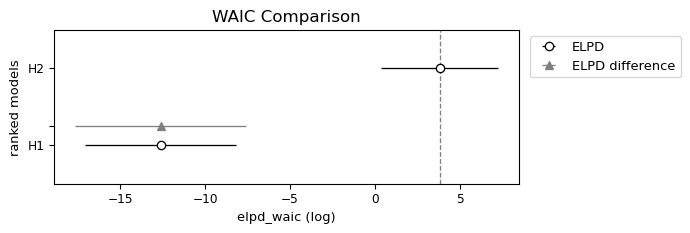

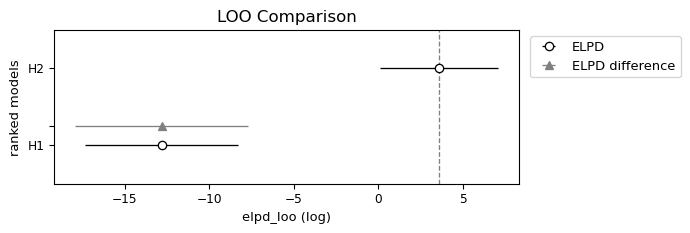

In [211]:
waic_comparison = az.compare({"H1": waic_h1, "H2": waic_h2}, ic="waic")
loo_comparison = az.compare({"H1": loo_h1, "H2": loo_h2}, ic="loo")

# Print comparison results
print("WAIC Comparison:")
print(waic_comparison)
print("\nLOO Comparison:")
print(loo_comparison)

# Plot WAIC comparison
az.plot_compare(waic_comparison)
plt.title("WAIC Comparison")
plt.show()

# Plot LOO comparison
az.plot_compare(loo_comparison)
plt.title("LOO Comparison")
plt.show()

H2 elpd_waic更大；elpd_loo更大，其假设更合理